In [1]:
from sympy import *
import numpy as np

init_printing(use_unicode=True)
from matplotlib import pyplot as plt
%matplotlib inline
from sympy.physics.quantum.dagger import Dagger
from sympy.physics.quantum import TensorProduct
import scipy.interpolate
import platform



In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

In [3]:
def id(n): 
    '''retorna a matriz identidade nxn'''
    id = zeros(n,n)
    for j in range(0,n):
       id[j,j] = 1
    return id
#id(2)

In [4]:
def cb(d, j):
    cbs = zeros(d,1); cbs[j] = 1
    return cbs


In [5]:
# Outside this function, initialize: evals = zeros(d,1)
def eVals(A):
    d = A.shape[0]; evals = zeros(d,1)
    eig = A.eigenvects()
    ne = 0
    j = 0
    lk = 0
    while ne < d:
        mult = eig[j][1]
        ne += mult
        nk = lk + mult
        for k in range(lk,nk):
            evals[k] = eig[j][0]
        lk = nk
        j += 1
    return evals

In [6]:
def mat_sqrt(A):
    d = A.shape[0]; eig = A.eigenvects(); Asqrt = zeros(d,d); ne = 0; j = 0; lk = 0
    while ne < d:
        mult = eig[j][1]; ne += mult
        for k in range(0,mult):
            Proj = proj(eig[j][2][k]); Asqrt += sqrt(eig[j][0])*(Proj/trace(Proj))
        j += 1
    return Asqrt
#mat_sqrt(pauli(3))

In [7]:
def proj(psi):
    return psi*Dagger(psi)

In [8]:
def tp(x,y):
    return TensorProduct(x,y)

In [9]:
def trace(A):
    d = A.shape[0]; tr = 0.0
    for j in range(0,d):
       tr += A[j,j]
    return tr

In [10]:
#def trace(d,A):
#    tr = 0
#    for j in range(0,d):
#        tr += A[j,j]
#    return tr

In [11]:
def Var(d,x,y):
    return trace(d,x*(y*y))-(trace(d,x*y))**2

In [12]:
def comm(x,y):
    return x*y-y*x

In [13]:
def mat_exp(A):
    d = A.shape[0]; eig = A.eigenvects(); Aexp = zeros(d,d); ne = 0; j = 0; lk = 0
    while ne < d:
        mult = eig[j][1]; ne += mult
        for k in range(0,mult):
            Proj = proj(eig[j][2][k]); Aexp += exp(eig[j][0])*(Proj/trace(Proj))
        j += 1
    return Aexp
#simplify(mat_exp(pauli(1)))

In [14]:
tha = symbols(' theta_a ', real=True, positive=True)
thb = symbols(' theta_b ', real=True, positive=True)
def psiA(tha):
    return cos(tha/2)*cb(2, 0) + sin(tha/2)*cb(2, 1)
def psiB(thb):
    return cos(thb/2)*cb(2, 0) + sin(thb/2)*cb(2, 1)
def PsiAB(tha,thb):
    return tp((cos(tha/2)*cb(2, 0) + sin(tha/2)*cb(2, 1)),(cos(thb/2)*cb(2, 0) + sin(thb/2)*cb(2, 1)))

In [15]:
def normTr(d, A):
    eva = eVals(d, A)
    TrNorm = 0
    for j in range(0,d):
        TrNorm += abs(eva[j])
    return TrNorm

In [16]:
def norm_tr(A):
    d = A.shape[0]; eva = eVals(A)
    TrNorm = 0
    for j in range(0,d):
        TrNorm += abs(eva[j])
    return TrNorm

In [17]:
def mat_sqrt(A):
    d = A.shape[0]; eig = A.eigenvects()
    Asqrt = zeros(d,d)
    ne = 0
    j = 0
    lk = 0
    while ne < d:
        mult = eig[j][1]
        ne += mult
        for k in range(0,mult):
            Proj = proj(eig[j][2][k])
            Asqrt += sqrt(eig[j][0])*(Proj/trace(Proj))
        j += 1
    return Asqrt

In [18]:
#def mat_sqrt(d,A):
#    eig = A.eigenvects()
#    Asqrt = zeros(d,d)
#    ne = 0
#    j = 0
#    lk = 0
#    while ne < d:
#        mult = eig[j][1]
#        ne += mult
#        for k in range(0,mult):
#            Proj = proj(eig[j][2][k])
#            Asqrt += sqrt(eig[j][0])*(Proj/trace(d,Proj))
#        j += 1
#    return Asqrt

In [19]:
Mais=(cb(2,0)+cb(2,1))/sqrt(2)
Menos=(cb(2,0)-cb(2,1))/sqrt(2)

In [20]:
def Pauli(j):
    if j == 0:
        return Matrix([[1,0],[0,1]])
    elif j == 1:
        return Matrix([[0,1],[1,0]])
    elif j == 2:
        return Matrix([[0,-1j],[1j,0]])
    elif j == 3:
        return Matrix([[1,0],[0,-1]])

In [28]:
a1,a2,a3,b1,b2,b3 = symbols('a_{1} a_{2} a_{3} b_{1} b_{2} b_{3}', real=True)
c11,c12,c13,c21,c22,c23,c31,c32,c33 = symbols('c_{11} c_{12} c_{13} c_{21} c_{22} c_{23} c_{31} c_{32} c_{33}', real=True)
def rho2qb(a1, a2, a3, b1, b2, b3, c11, c12, c13, c21, c22, c23, c31, c32, c33):
    return ((tp(Pauli(0),Pauli(0)) + b1*tp(Pauli(0),Pauli(1)) + b2*tp(Pauli(0),Pauli(2)) + b3*tp(Pauli(0),Pauli(3))
           + a1*tp(Pauli(1),Pauli(0)) + c11*tp(Pauli(1),Pauli(1)) + c12*tp(Pauli(1),Pauli(2)) + c13*tp(Pauli(1),Pauli(3))
           + a2*tp(Pauli(2),Pauli(0)) + c21*tp(Pauli(2),Pauli(1)) + c22*tp(Pauli(2),Pauli(2)) + c23*tp(Pauli(2),Pauli(3))
           + a3*tp(Pauli(3),Pauli(0)) + c31*tp(Pauli(3),Pauli(1)) + c32*tp(Pauli(3),Pauli(2)) + c33*tp(Pauli(3),Pauli(3))))/4

#def rho2qb(CM):
 #   return ((tp(Pauli(0),Pauli(0)) + CM[0,1]*tp(Pauli(0),Pauli(1)) + CM[0,2]*tp(Pauli(0),Pauli(2)) + CM[0,3]*tp(Pauli(0),Pauli(3))
  #         + CM[1,0]*tp(Pauli(1),Pauli(0)) + CM[1,1]*tp(Pauli(1),Pauli(1)) + CM[1,2]*tp(Pauli(1),Pauli(2)) + CM[1,3]*tp(Pauli(1),Pauli(3))
   #        + CM[2,0]*tp(Pauli(2),Pauli(0)) + CM[2,1]*tp(Pauli(2),Pauli(1)) + CM[2,2]*tp(Pauli(2),Pauli(2)) + CM[2,3]*tp(Pauli(2),Pauli(3))
    #       + CM[3,0]*tp(Pauli(3),Pauli(0)) + CM[3,1]*tp(Pauli(3),Pauli(1)) + CM[3,2]*tp(Pauli(3),Pauli(2)) + CM[3,3]*tp(Pauli(3),Pauli(3))))/4

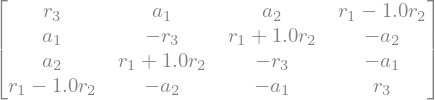

In [29]:
r1*tp(Pauli(1),Pauli(1)) +r2*tp(Pauli(2),Pauli(2)) +r3*tp(Pauli(3),Pauli(3)) + a1*tp(Pauli(3),Pauli(1)) +a2*tp(Pauli(1),Pauli(3))

In [22]:
r1, r2, r3 = symbols('r_{1} r_{2} r_{3}', real=True)
def rho1qb(r1, r2, r3):
    return ((Pauli(0) + r1*Pauli(1) + r2*Pauli(2) + r3*Pauli(3)))/2

In [24]:
def Bell(j,k):
    if j == 0 and k == 0:
        return Matrix([[1/sqrt(2)],[0],[0],[1/sqrt(2)]]) # phi+
    elif j == 0 and k == 1:
        return Matrix([[0],[1/sqrt(2)],[1/sqrt(2)],[0]]) # psi+
    elif j == 1 and k == 0:
        return Matrix([[1/sqrt(2)],[0],[0],[-1/sqrt(2)]]) # phi-
    elif j == 1 and k == 1:
        return Matrix([[0],[1/sqrt(2)],[-1/sqrt(2)],[0]]) # psi-

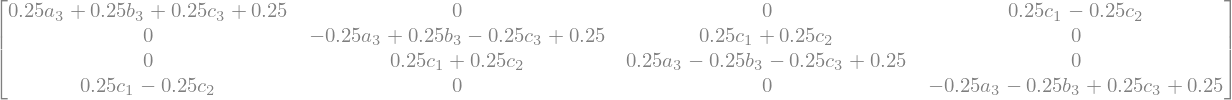

In [26]:
def rho_x(c1,c2,c3,a3,b3):
    return (1/4)*(tp(id(2),id(2))+c1*tp(Pauli(1),Pauli(1))+c2*tp(Pauli(2),Pauli(2))+c3*tp(Pauli(3),Pauli(3))
                  +a3*tp(id(2),Pauli(3))+b3*tp(Pauli(3),id(2)))
c1, c2, c3, a3, b3 = symbols('c_{1} c_{2} c_{3} a_3 b_3', real=True)
rhox = rho_x(c1,c2,c3,a3,b3); rhox

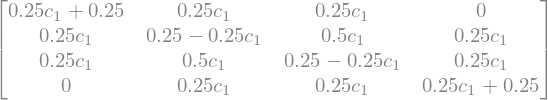

In [30]:
def rho_bd_x(c1,c2,c3,a1,b1,a3,b3):
    return (1/4)*(tp(id(2),id(2))+c1*tp(Pauli(1),Pauli(1))+c2*tp(Pauli(2),Pauli(2))+c3*tp(Pauli(3),Pauli(3))
                  +b1*tp(id(2),Pauli(1))+a1*tp(Pauli(1),id(2))+b3*tp(id(2),Pauli(3))+a3*tp(Pauli(3),id(2)))
c1, c2, c3, a1, b1, a3, b3 = symbols('c_{1} c_{2} c_{3} a_1 b_1 a_3 b_3', real=True)
rho_bd_x = rho_bd_x(c1,c1,c1,c1,c1,0,0); rho_bd_x

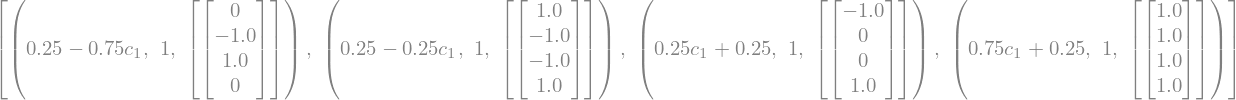

In [31]:
rho_bd_x.eigenvects()

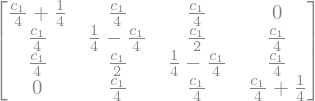

In [94]:
def rho_thermal(c1,c3,beta):
    return (((1+3*c1+c3)/4)*proj(tp(Mais,Mais))+((1+c1+3*c3)/4)*proj(Bell(1,0))+((1-c1-3*c3)/4)*proj(tp(Menos,Menos))+((1-3*c1+c3)/4)*proj(Bell(1,1)))/trace(((1+3*c1+c3)/4)*proj(tp(Mais,Mais))+((1+c1+3*c3)/4)*proj(Bell(1,0))+((1-c1-3*c3)/4)*proj(tp(Menos,Menos))+((1-3*c1+c3)/4)*proj(Bell(1,1)))

simplify(rho_thermal(c1,0,beta))

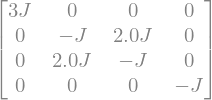

In [34]:
J1, J2, J3, J = symbols('J_{1} J_{2} J_{3} J', real=True)
H_Heis = J*tp(Pauli(1),Pauli(1)) + J*tp(Pauli(2),Pauli(2)) + J*tp(Pauli(3),Pauli(3)) + J*tp(Pauli(0),Pauli(3)) + J*tp(Pauli(3),Pauli(0));H_Heis

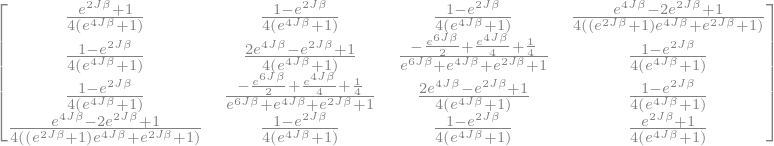

In [37]:
beta = symbols('beta', real=True)
def Thermal_state(J,beta):
    return (exp(-3*J*beta)*proj(tp(Mais,Mais))+\
           exp(-J*beta)*proj(Bell(1,0))+\
           exp(J*beta)*proj(tp(Menos,Menos))+\
           exp(3*J*beta)*proj(Bell(1,1)))/trace(exp(-3*J*beta)*proj(tp(Mais,Mais)) + exp(-J*beta)*proj(Bell(1,0))+exp(J*beta)*proj(tp(Menos,Menos))+exp(3*J*beta)*proj(Bell(1,1)))

simplify((Thermal_state(J,beta)))

In [259]:
concurrence(Thermal_state(1,1))

In [ ]:
########################################

In [43]:
from sympy import Symbol, Interval
p = symbols('p', real=True, positive= True)
def Bell_like(p,j,k):
    if j == 0 and k == 0:
        return Matrix([[sqrt(p)],[0],[0],[sqrt(1-p)]]) # phi+
    elif j == 0 and k == 1:
        return Matrix([[0],[sqrt(p)],[sqrt(1-p)],[0]]) # psi+
    elif j == 1 and k == 0:
        return Matrix([[sqrt(p)],[0],[0],[-sqrt(1-p)]]) # phi-
    elif j == 1 and k == 1:
        return Matrix([[0],[sqrt(p)],[-sqrt(1-p)],[0]]) # psi-

In [31]:
import numpy as np

def Bell_like_num(p, j, k):
    if j == 0 and k == 0:
        return np.array([[np.sqrt(p)], [0], [0], [np.sqrt(1-p)]])  # phi+
    elif j == 0 and k == 1:
        return np.array([[0], [np.sqrt(p)], [np.sqrt(1-p)], [0]])  # psi+
    elif j == 1 and k == 0:
        return np.array([[np.sqrt(p)], [0], [0], [-np.sqrt(1-p)]])  # phi-
    elif j == 1 and k == 1:
        return np.array([[0], [np.sqrt(p)], [-np.sqrt(1-p)], [0]])  # psi-


### Bell-diagonal states
\begin{align}
\rho & = \frac{1}{4}\left(\sigma_{0}\otimes\sigma_{0} + \sum_{j=1}^{3}c_{j}\sigma_{j}\otimes\sigma_{j}\right) \\
& = \frac{1}{4}
\begin{bmatrix}
1+c_{3} & 0 & 0 & c_{1}-c_{2} \\
0 & 1-c_{3} & c_{1}+c_{2} & 0 \\
0 & c_{1}+c_{2} & 1-c_{3} & 0 \\
c_{1}-c_{2} & 0 & 0 & 1+c_{3}
\end{bmatrix}
\end{align}

In [50]:
c1, c2, c3 = symbols('c_{1} c_{2} c_{3}', real=True)
def bds(c1,c2,c3):
    return ((tp(Pauli(0),Pauli(0)) + c1*tp(Pauli(1),Pauli(1)) + c2*tp(Pauli(2),Pauli(2)) + c3*tp(Pauli(3),Pauli(3))))/4

### Werner state
\begin{equation}
\rho_{w} = (1-w)\frac{\mathbb{I}_{4}}{4} + w|\beta_{jk}\rangle\langle\beta_{jk}|
\end{equation}

In [51]:
def werner(w,j,k):
    return (1-w)*tp(Pauli(0),Pauli(0))/4 + w*proj(Bell(j,k))
w = symbols('w', real=True, positive=True); #bds(-w,-w,-w)-werner(w)

### Werner-like state
\begin{equation}
\rho_{w} = (1-w)\frac{\mathbb{I}_{4}}{4} + w|\beta'_{jk}\rangle\langle\beta'_{jk}|
\end{equation}



In [34]:

a1,a2,a3,b1,b2,b3 = symbols('a_{1} a_{2} a_{3} b_{1} b_{2} b_{3}', real=True)
c11,c12,c13,c21,c22,c23,c31,c32,c33 = symbols('c_{11} c_{12} c_{13} c_{21} c_{22} c_{23} c_{31} c_{32} c_{33}', real=True)
def rho2qb(a1, a2, a3, b1, b2, b3, c11, c12, c13, c21, c22, c23, c31, c32, c33):
    return ((tp(Pauli(0),Pauli(0)) + b1*tp(Pauli(0),Pauli(1)) + b2*tp(Pauli(0),Pauli(2)) + b3*tp(Pauli(0),Pauli(3))
           + a1*tp(Pauli(1),Pauli(0)) + c11*tp(Pauli(1),Pauli(1)) + c12*tp(Pauli(1),Pauli(2)) + c13*tp(Pauli(1),Pauli(3))
           + a2*tp(Pauli(2),Pauli(0)) + c21*tp(Pauli(2),Pauli(1)) + c22*tp(Pauli(2),Pauli(2)) + c23*tp(Pauli(2),Pauli(3))
           + a3*tp(Pauli(3),Pauli(0)) + c31*tp(Pauli(3),Pauli(1)) + c32*tp(Pauli(3),Pauli(2)) + c33*tp(Pauli(3),Pauli(3))))/4

#def rho2qb(CM):
 #   return ((tp(Pauli(0),Pauli(0)) + CM[0,1]*tp(Pauli(0),Pauli(1)) + CM[0,2]*tp(Pauli(0),Pauli(2)) + CM[0,3]*tp(Pauli(0),Pauli(3))
  #         + CM[1,0]*tp(Pauli(1),Pauli(0)) + CM[1,1]*tp(Pauli(1),Pauli(1)) + CM[1,2]*tp(Pauli(1),Pauli(2)) + CM[1,3]*tp(Pauli(1),Pauli(3))
   #        + CM[2,0]*tp(Pauli(2),Pauli(0)) + CM[2,1]*tp(Pauli(2),Pauli(1)) + CM[2,2]*tp(Pauli(2),Pauli(2)) + CM[2,3]*tp(Pauli(2),Pauli(3))
    #       + CM[3,0]*tp(Pauli(3),Pauli(0)) + CM[3,1]*tp(Pauli(3),Pauli(1)) + CM[3,2]*tp(Pauli(3),Pauli(2)) + CM[3,3]*tp(Pauli(3),Pauli(3))))/4

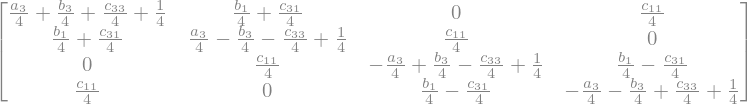

In [332]:
rho2qb(0, 0, a3, b1, 0, b3, c11, 0, 0, 0, 0, 0, c31, 0, c33)

In [52]:
def Kad(j, a):
    if j == 0:
        return Matrix([[0,sqrt(a)],[0,0]])
    elif j == 1:
        return Matrix([[1,0],[0,sqrt(1-a)]])
def ADC(rho, a):
    return Kad(0, a)*rho*(Kad(0, a).T) + Kad(1, a)*rho*Kad(1, a)

In [53]:
def coh_l1(rho):
    d = rho.shape[0]; C = 0
    for j in range(0,d-1):
        for k in range(j+1,d):
            C += abs(rho[j,k])
    return 2*C

In [54]:
def concurrence(rho):
    R = rho*tp(Pauli(2),Pauli(2))*conjugate(rho)*tp(Pauli(2),Pauli(2))
    evals = zeros(4,1)
    ev = eVals(R)
    evm = max(abs(ev[0]), abs(ev[1]), abs(ev[2]), abs(ev[3]))
    C = 2.0*sqrt(abs(evm)) - sqrt(abs(ev[0])) - sqrt(abs(ev[1])) - sqrt(abs(ev[2])) - sqrt(abs(ev[3]))
    if C < 0.0:
        C = 0.0
    return C

In [55]:
concurrence(proj(Bell(1,1)))

In [ ]:
concurrence(werner(1))

In [56]:
# Outside these functions, initialize: rhos = zeros(ds,ds), s=A,B
def ptraceA(da, db, rho):
    rhoB = zeros(db,db)
    for j in range(0, db):
        for k in range(0, db):
            for l in range(0, da):
                rhoB[j,k] += rho[l*db+j,l*db+k]
    return rhoB
def ptraceB(da, db, rho):
    rhoA = zeros(da,da)
    for j in range(0, da):
        for k in range(0, da):
            for l in range(0, db):
                rhoA[j,k] += rho[j*db+l,k*db+l]
    return rhoA

In [57]:
def ptranspose(da,db,rho,ssys):
    ptp = zeros(da*db,da*db)
    if ssys == 'b':
        for ja in range(0,da):
            for ka in range(0,da):
                for jb in range(0,db):
                    for kb in range(0,db):
                        ptp[ja*db+kb,ka*db+jb] = rho[ja*db+jb,ka*db+kb]
    elif ssys == 'a':
        for ja in range(0,da):
            for ka in range(0,da):
                for jb in range(0,db):
                    for kb in range(0,db):
                        ptp[ka*db+jb,ja*db+kb] = rho[ja*db+jb,ka*db+kb]
    return ptp

In [58]:
# outside this function, initialize: rhoTb = zeros(4,4); evals = zeros(4,1)
def negativity(da, db, rho):
    d = da*db
    rhoTb = ptranspose(da, db, rho,'b')
    En = (norm_tr(rhoTb) - 1)/2
    return En

#### Estado $|\Phi_{+}^{3}\rangle$

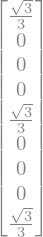

In [32]:
Phi_qutrit = (tp(cb(3,0),cb(3,0)) + tp(cb(3,1),cb(3,1)) + tp(cb(3,2),cb(3,2)))/sqrt(3) ;Phi_qutrit

### Canal Phase FLIP NÃO MARKOVIANO

In [ ]:
from sympy import *
import numpy as np

init_printing(use_unicode=True)
from matplotlib import pyplot as plt
%matplotlib inline
from sympy.physics.quantum.dagger import Dagger
from sympy.physics.quantum import TensorProduct
import scipy.interpolate
import platform

In [34]:
def cb(d, j):
    cbs = zeros(d,1); cbs[j] = 1
    return cbs
def proj(psi):
    return psi*Dagger(psi)

def coh_l1(rho):
    d = rho.shape[0]; C = 0
    for j in range(0,d-1):
        for k in range(j+1,d):
            C += abs(rho[j,k])
    return 2*C

In [ ]:
Mais=(cb(2,0)+cb(2,1))/sqrt(2)
Menos=(cb(2,0)-cb(2,1))/sqrt(2)

In [ ]:
def K_0(alpha,J):
    return sqrt(exp(-alpha*J)*(cos(J/2)+alpha*sin(J/2)))*Pauli(0)

K_0(0.01,1.2)

In [ ]:
def K_1(alpha,J):
    return sqrt(1-exp(-alpha*J)*(cos(J/2)+alpha*sin(J/2)))*Pauli(3)

K_1(0.01,1.2)

In [ ]:
#ação do canal no estado |+><+| J É O TEMPO
def RHO_t_NM(J):
    return K_0(0.01,J)*proj(Mais)*K_0(0.01,J).T + K_1(0.01,J)*proj(Mais)*K_1(0.01,J).T

RHO_t_NM(1.2)

In [ ]:
RHO_t_NM(0)

In [ ]:
coh_l1(RHO_t_NM(0))

In [ ]:
RHO_t_NM(0.5)

In [ ]:
coh_l1(RHO_t_NM(0.5))

In [ ]:
t = np.linspace(0,100,100)
y = [coh_l1(RHO_t_NM(i)) for i in t]
plt.plot(t,y)
plt.show()